# RL and Advanced DL: Домашнее задание 1

## Часть 1

Студент Черников Дмитрий, ML-32

In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from collections import defaultdict
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from tqdm import tqdm

np.set_printoptions(precision=6, suppress=True)

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [2]:
env = gym.make('Blackjack-v0', natural=True)
env

## Baseline

__Тривиальная стратегия - не добирать.__

Базовый класс для стратегий, реализует оценку first visit Monte Carlo estimation для V- и Q-функций

In [3]:
EPISODES = 1_000_000

N_STATES=32
N_ACTIONS=2

DIALER=17
SHORTFALL=12

class BaselineStrategy:
    """
    Тривиальная стратегия - не добирать.
    """
    def __init__(self, n_states=N_STATES, n_actions=N_ACTIONS):
        self.n_states, self.n_actions = n_states, n_actions
        self.states, self.actions, self.rewards = [], [], []
        
        self.V = defaultdict(float)
        self.RetS = defaultdict(int)
        self.Q = defaultdict(lambda: [np.random.uniform() for _ in range(n_actions)])
        self.RetSA = defaultdict(lambda: [0 for _ in range(n_actions)])
        
    def __str__(self):
        return "BaselineStrategy"
    
    def new_episode(self):
        self.states, self.rewards, self.actions = [], [], []
        
    def action(self, state):
        return 0
    
    def collect(self, state, action, reward, state_next):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        
    def first_visit_mc(self):
        # first visit Monte Carlo estimation 
        G = 0
        for t in range(len(self.states)-1, -1, -1):
            S, A, R = self.states[t], self.actions[t], self.rewards[t]
            G += R
            if S not in self.states[:t]:
                self.RetS[S] += 1
                self.V[S] += (G - self.V[S]) / self.RetS[S]
                self.RetSA[S][A] += 1
                self.Q[S][A] += (G - self.Q[S][A]) / self.RetSA[S][A]


In [4]:
def run_episode(strategy, env):
    # reset states, actions, rewards
    strategy.new_episode()

    env.reset()

    reward = 0.0
    is_done = False
    while not is_done:
        state = env._get_obs()
        action = strategy.action(state)
        observation, reward, is_done, _ = env.step(action)
        # append states, actions, rewards
        strategy.collect(state, action, reward, observation)
        
    env.close()
    return reward


In [5]:
def first_visit_mc_estimation(strategy,
                              env=gym.make('Blackjack-v0', natural=True),
                              n_episodes=10000,
                              random_seed=None):
    
    if random_seed is not None:
        env.seed(random_seed)
        env.action_space.seed(random_seed)
    np.random.seed(random_seed)
    
    rewards = []
    for i in range(n_episodes):
        reward = run_episode(strategy, env)
        rewards.append(reward)
        strategy.first_visit_mc()

    return np.true_divide(np.cumsum(rewards), np.arange(n_episodes) + 1)

In [6]:
# collection of strategies
strats = {}

def run_estimation(strategy,
                   env=gym.make('Blackjack-v0', natural=True),
                   n_episodes=EPISODES,
                   strats=strats,
                   display_result=True,
                   min_rewards=-1.0):
    
    #run estimation
    wins = first_visit_mc_estimation(strategy, env=env, n_episodes=n_episodes)
    
    # add to result dataframe
    strats[str(strategy)] = { "strategy": strategy, "result": wins[-1], "wins": wins}
    
    # display results
    if display_result:
        display(f"{strategy}: result = {wins[-1]}")
            
    # plot avg rewards
    if wins[-1] >= min_rewards:
        plt.plot(wins, label=strategy)
        
    return wins

'BaselineStrategy: result = -0.1661595'

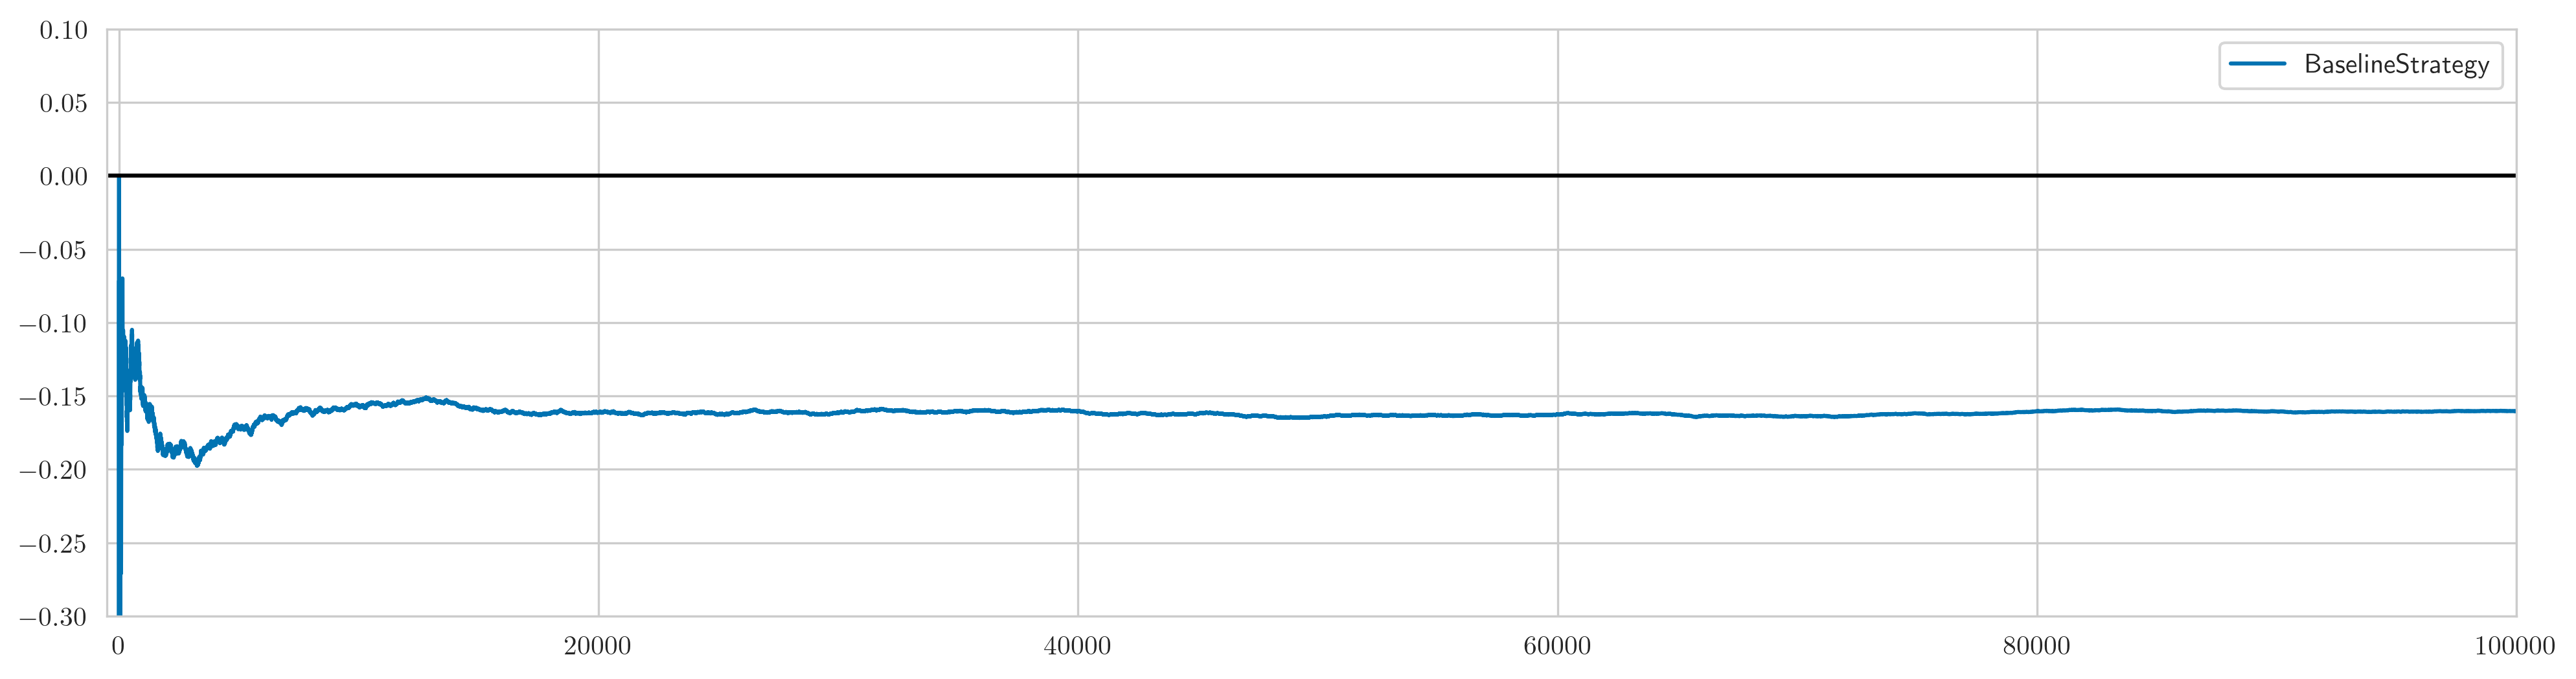

In [7]:
plt.figure(figsize=(16,4))

baseline_strategy = BaselineStrategy()
baseline_strategy_wins = run_estimation(baseline_strategy)

plt.axhline(y=0.0, color='black')
plt.xlim((-500, 100000))
plt.ylim((-0.3, 0.1))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Часть первая, с блекджеком и стратегиями

- 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

- 3. Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [9]:
class SimpleStrategy(BaselineStrategy):
    """
    Простая стратегия - добирать пока на руках меньше `stand`
    """
    
    def __init__(self, stand=DIALER, n_states=N_STATES, n_actions=N_ACTIONS):
        super().__init__(n_states=n_states, n_actions=n_actions)
        self.stand = stand
        
    def __str__(self):
        return f"SimpleStrategy(stand={self.stand})"
    
    def action(self, state):
        return 1 if state[0] < self.stand else 0


'BaselineStrategy: result = -0.1659675'

'SimpleStrategy(stand=11): result = -0.1191855'

'SimpleStrategy(stand=12): result = -0.0851895'

'SimpleStrategy(stand=13): result = -0.0715345'

'SimpleStrategy(stand=14): result = -0.0596015'

'SimpleStrategy(stand=15): result = -0.0539715'

'SimpleStrategy(stand=16): result = -0.054985'

'SimpleStrategy(stand=17): result = -0.0574805'

'SimpleStrategy(stand=18): result = -0.091689'

'SimpleStrategy(stand=19): result = -0.1792825'

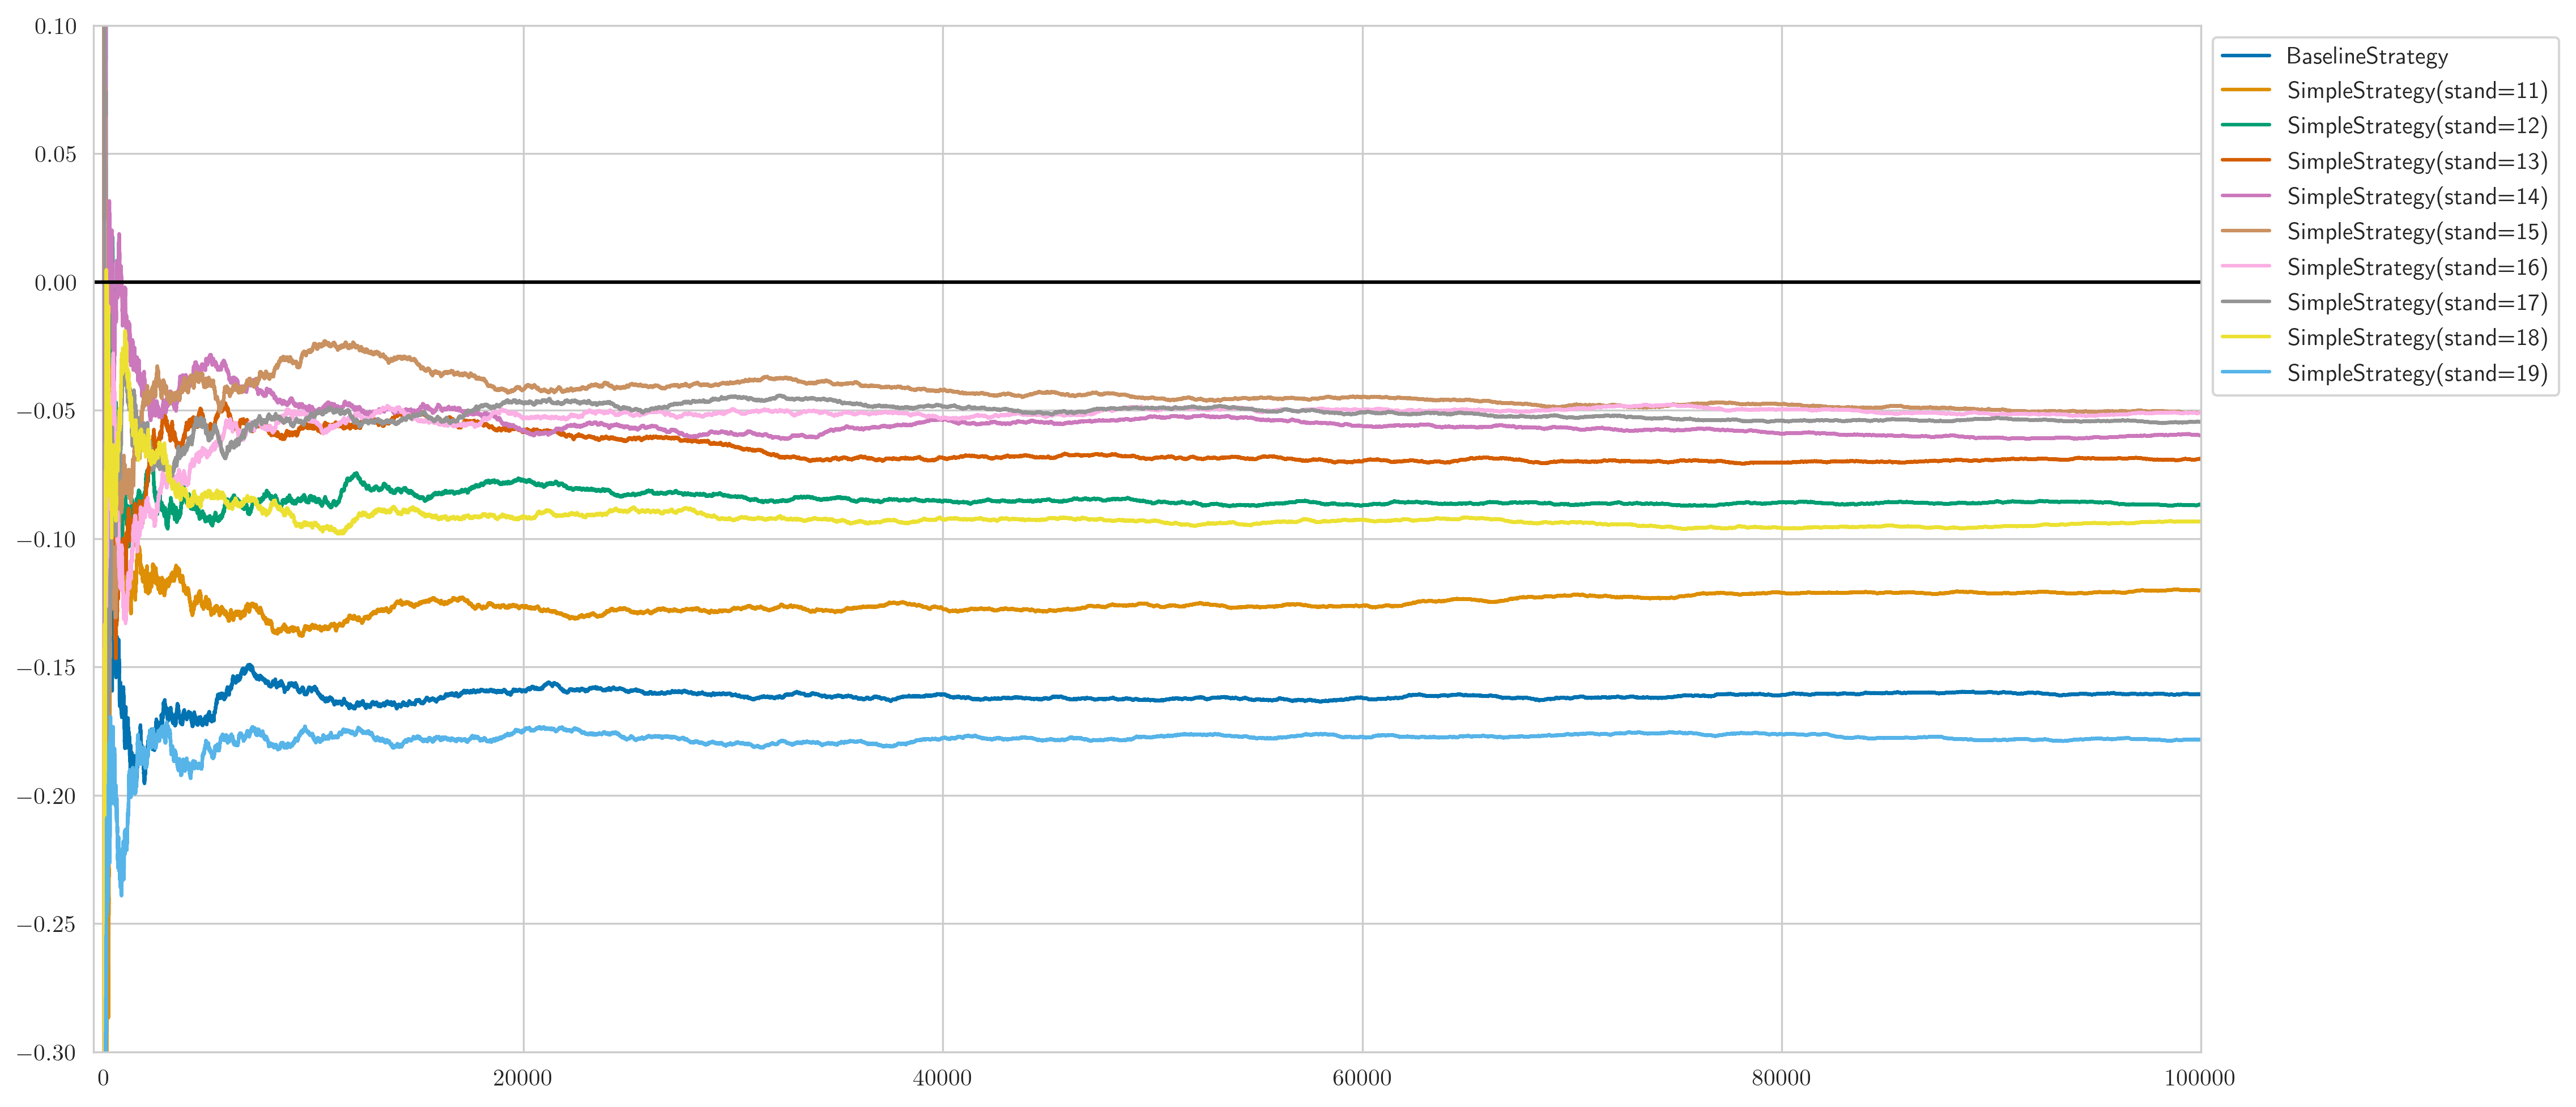

In [10]:
plt.figure(figsize=(16,8))

baseline_strategy = BaselineStrategy()
baseline_strategy_wins = run_estimation(baseline_strategy)

for stand in range(11, 20):
    strategy = SimpleStrategy(stand=stand)
    run_estimation(strategy)
    
plt.axhline(y=0.0, color='black')
plt.xlim((-500, 100000))
plt.ylim((-0.3, 0.1))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [11]:
df = pd.DataFrame(strats).T.sort_values(by="result",ascending=False)

best_strategy_name = df.index[0]
best_strategy = strats[best_strategy_name]["strategy"]
best_strategy_wins = strats[best_strategy_name]["wins"]

df

,strategy,result,wins
SimpleStrategy(stand=15),SimpleStrategy(stand=15),-0.053971,"[-1.0, 0.0, 0.3333333333333333, 0.0, -0.2, -0...."
SimpleStrategy(stand=16),SimpleStrategy(stand=16),-0.054985,"[-1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -..."
SimpleStrategy(stand=17),SimpleStrategy(stand=17),-0.05748,"[1.0, 1.25, 1.1666666666666667, 0.625, 0.5, 0...."
SimpleStrategy(stand=14),SimpleStrategy(stand=14),-0.059602,"[0.0, 0.5, 0.0, -0.25, 0.0, 0.1666666666666666..."
SimpleStrategy(stand=13),SimpleStrategy(stand=13),-0.071535,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -0..."
SimpleStrategy(stand=12),SimpleStrategy(stand=12),-0.08519,"[1.0, 1.0, 1.0, 0.5, 0.2, 0.3333333333333333, ..."
SimpleStrategy(stand=18),SimpleStrategy(stand=18),-0.091689,"[-1.0, -1.0, -0.3333333333333333, -0.5, -0.4, ..."
SimpleStrategy(stand=11),SimpleStrategy(stand=11),-0.119185,"[-1.0, -1.0, -0.3333333333333333, -0.5, -0.2, ..."
BaselineStrategy,BaselineStrategy,-0.165967,"[1.0, 0.0, -0.3333333333333333, 0.0, -0.2, 0.0..."
SimpleStrategy(stand=19),SimpleStrategy(stand=19),-0.179283,"[-1.0, -1.0, -1.0, -0.5, -0.6, -0.333333333333..."


In [12]:
class SoftStandStrategy(SimpleStrategy):
    """
    Мягкая простая стратегия - добирать с вероятностью `eps` пока на руках меньше `stand`
    """
    
    def __init__(self, eps=0.95, stand=DIALER, n_states=N_STATES, n_actions=N_ACTIONS):
        super().__init__(stand=stand, n_states=n_states, n_actions=n_actions)
        self.eps = eps
        
    def __str__(self):
        return f"SoftStandStrategy(eps={self.eps}, stand={self.stand})"

    def action(self, state):
        return 1 if state[0] < self.stand and np.random.uniform() < self.eps else 0
    
class SoftHitStrategy(SoftStandStrategy):
    """
    Мягкая простая стратегия - добирать все время пока меньше `hit`,
    потом добирать с вероятностью `eps` пока на руках меньше `stand`
    """
    
    def __init__(self, eps=0.95, stand=DIALER, hit=SHORTFALL, n_states=N_STATES, n_actions=N_ACTIONS):
        super().__init__(eps=eps, stand=stand, n_states=n_states, n_actions=n_actions)
        self.hit = hit
        
    def __str__(self):
        return f"SoftHitStrategy(eps={self.eps}, hit={self.hit}, stand={self.stand})"

    def action(self, state):
        return 1 if state[0] < self.hit else super().action(state)


100%|████████████████████████████████████████████| 7/7 [59:16<00:00, 508.09s/it]


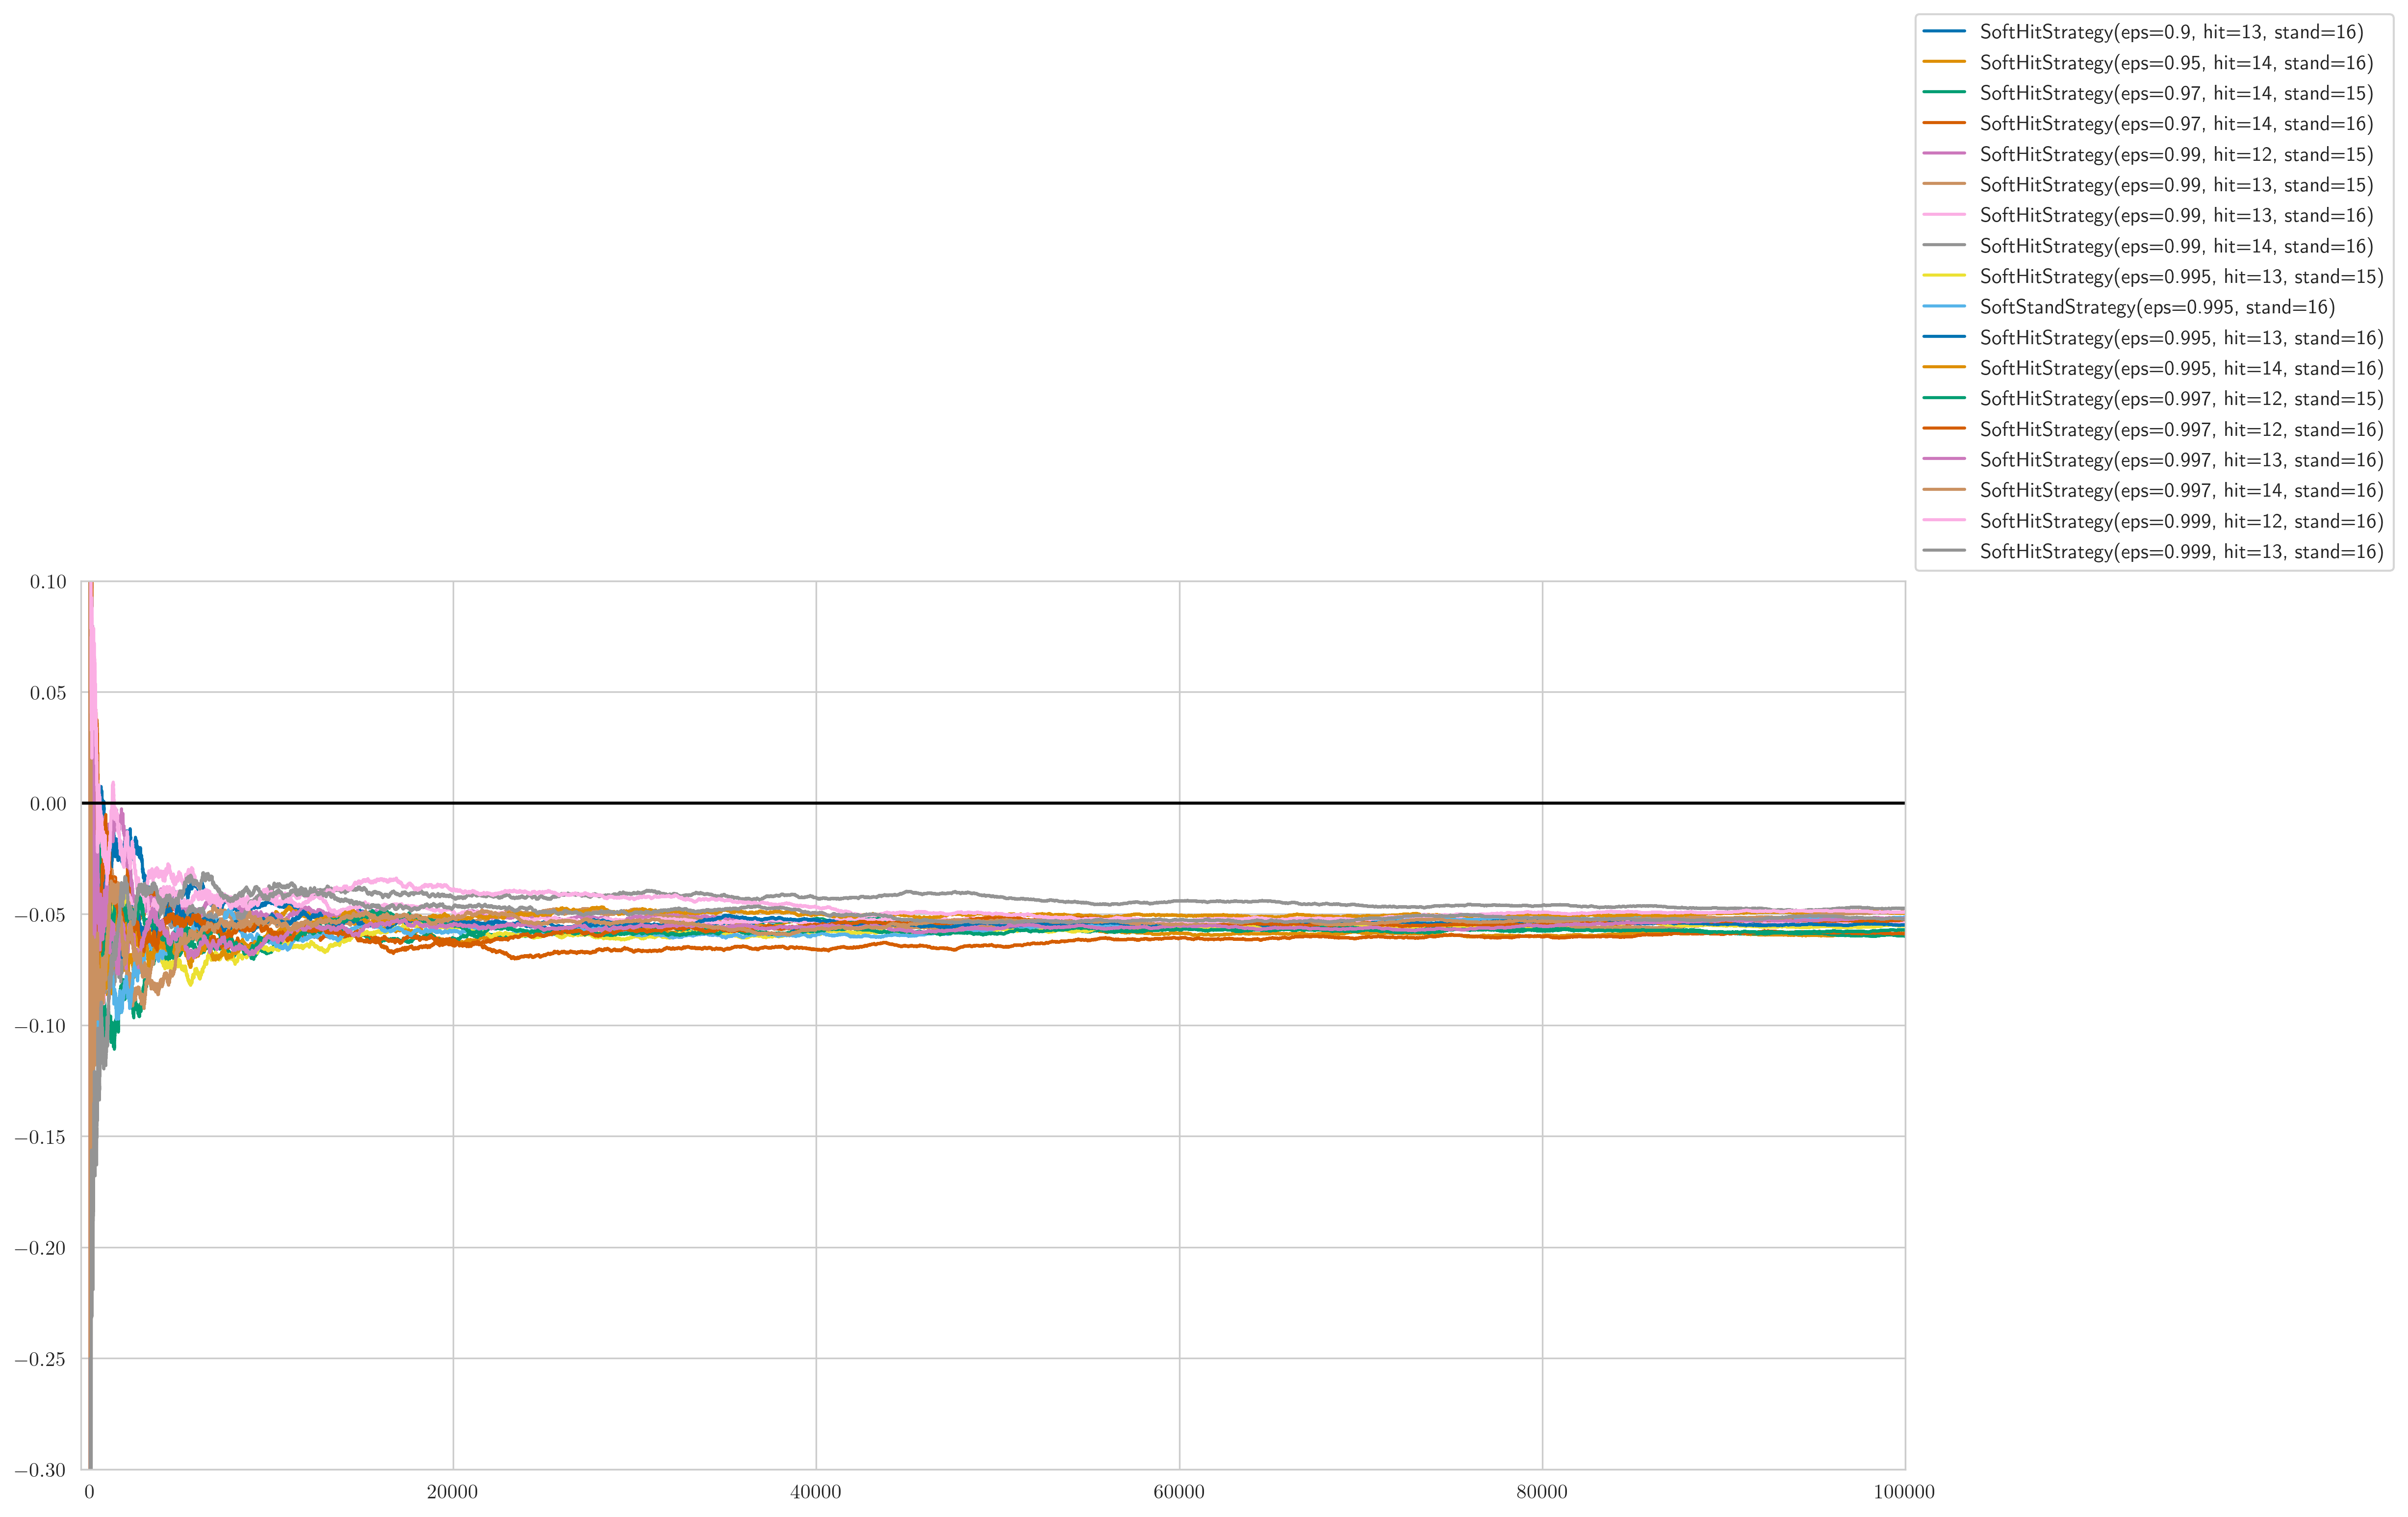

In [13]:
MIN_REWARDS = -0.055

plt.figure(figsize=(16,8))

for eps in tqdm([0.9, 0.95, 0.97, 0.99, 0.995, 0.997, 0.999]):
    for stand in [15, 16, 17]:
        strategy = SoftStandStrategy(eps=eps, stand=stand)
        run_estimation(strategy, display_result=False, min_rewards=MIN_REWARDS)
        
        for hit in [12, 13, 14]:
            strategy = SoftHitStrategy(eps=eps, hit=hit, stand=stand)
            run_estimation(strategy, display_result=False, min_rewards=MIN_REWARDS)

plt.axhline(y=0.0, color='black')
plt.xlim((-500, 100000))
plt.ylim((-0.3, 0.1))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [14]:
df = pd.DataFrame(strats).T \
    .sort_values(by="result",ascending=False)
df.head(10)

,strategy,result,wins
"SoftHitStrategy(eps=0.999, hit=13, stand=16)","SoftHitStrategy(eps=0.999, hit=13, stand=16)",-0.052585,"[-1.0, -1.0, -1.0, -1.0, -0.8, -0.833333333333..."
"SoftHitStrategy(eps=0.99, hit=13, stand=15)","SoftHitStrategy(eps=0.99, hit=13, stand=15)",-0.052795,"[1.0, 1.0, 0.3333333333333333, 0.0, -0.2, -0.3..."
"SoftHitStrategy(eps=0.99, hit=14, stand=16)","SoftHitStrategy(eps=0.99, hit=14, stand=16)",-0.053191,"[1.0, 0.0, -0.3333333333333333, 0.0, -0.2, 0.0..."
"SoftHitStrategy(eps=0.99, hit=13, stand=16)","SoftHitStrategy(eps=0.99, hit=13, stand=16)",-0.053747,"[-1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -..."
"SoftHitStrategy(eps=0.97, hit=14, stand=16)","SoftHitStrategy(eps=0.97, hit=14, stand=16)",-0.053823,"[1.0, 1.0, 0.3333333333333333, 0.5, 0.2, 0.333..."
"SoftHitStrategy(eps=0.997, hit=14, stand=16)","SoftHitStrategy(eps=0.997, hit=14, stand=16)",-0.053892,"[0.0, -0.5, 0.0, 0.25, 0.4, 0.5, 0.57142857142..."
SimpleStrategy(stand=15),SimpleStrategy(stand=15),-0.053971,"[-1.0, 0.0, 0.3333333333333333, 0.0, -0.2, -0...."
"SoftHitStrategy(eps=0.97, hit=14, stand=15)","SoftHitStrategy(eps=0.97, hit=14, stand=15)",-0.05404,"[-1.0, -1.0, -1.0, -0.75, -0.4, -0.16666666666..."
"SoftHitStrategy(eps=0.95, hit=14, stand=16)","SoftHitStrategy(eps=0.95, hit=14, stand=16)",-0.054073,"[-1.0, -1.0, -1.0, -0.75, -0.8, -0.66666666666..."
"SoftHitStrategy(eps=0.995, hit=13, stand=16)","SoftHitStrategy(eps=0.995, hit=13, stand=16)",-0.054123,"[-1.0, -1.0, -1.0, -1.0, -0.5, -0.25, -0.21428..."


In [15]:
df.tail(10)

,strategy,result,wins
"SoftStandStrategy(eps=0.9, stand=16)","SoftStandStrategy(eps=0.9, stand=16)",-0.064418,"[1.0, 0.0, 0.3333333333333333, 0.0, 0.0, -0.16..."
"SoftStandStrategy(eps=0.95, stand=17)","SoftStandStrategy(eps=0.95, stand=17)",-0.065831,"[-1.0, 0.0, -0.3333333333333333, 0.125, 0.3, 0..."
"SoftStandStrategy(eps=0.9, stand=15)","SoftStandStrategy(eps=0.9, stand=15)",-0.06981,"[1.0, 0.0, 0.3333333333333333, 0.0, 0.2, 0.166..."
"SoftStandStrategy(eps=0.9, stand=17)","SoftStandStrategy(eps=0.9, stand=17)",-0.070253,"[1.5, 1.25, 1.1666666666666667, 1.125, 0.9, 0...."
SimpleStrategy(stand=13),SimpleStrategy(stand=13),-0.071535,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -0..."
SimpleStrategy(stand=12),SimpleStrategy(stand=12),-0.08519,"[1.0, 1.0, 1.0, 0.5, 0.2, 0.3333333333333333, ..."
SimpleStrategy(stand=18),SimpleStrategy(stand=18),-0.091689,"[-1.0, -1.0, -0.3333333333333333, -0.5, -0.4, ..."
SimpleStrategy(stand=11),SimpleStrategy(stand=11),-0.119185,"[-1.0, -1.0, -0.3333333333333333, -0.5, -0.2, ..."
BaselineStrategy,BaselineStrategy,-0.165967,"[1.0, 0.0, -0.3333333333333333, 0.0, -0.2, 0.0..."
SimpleStrategy(stand=19),SimpleStrategy(stand=19),-0.179283,"[-1.0, -1.0, -1.0, -0.5, -0.6, -0.333333333333..."


In [16]:
df_soft = df[df.index.str.startswith("Soft")]

best_soft_strategy_name = df_soft.index[0] 
best_soft_strategy = strats[best_soft_strategy_name]["strategy"]
best_soft_strategy_wins = strats[best_soft_strategy_name]["wins"]

display(f"{best_strategy}: result = {best_strategy_wins[-1]}")
display(f"{best_soft_strategy}: result = {best_soft_strategy_wins[-1]}")

'SimpleStrategy(stand=15): result = -0.0539715'

'SoftHitStrategy(eps=0.999, hit=13, stand=16): result = -0.052585'

## Методы обучения с подкреплением

- 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

- 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [17]:
class MCControlStrategy(BaselineStrategy):
    """
    Monte Carlo control with exploring starts
    """
    
    def __init__(self, seed=None, n_states=N_STATES, n_actions=N_ACTIONS):
        super().__init__(n_states=n_states, n_actions=n_actions)
        self.seed = seed
        
        np.random.seed(seed)
        self.Q = defaultdict(lambda: [np.random.uniform() for _ in range(n_actions)])
        
    def __str__(self):
        return f"MCControlStrategy(seed={self.seed})"

    def action(self, state):
        return np.argmax(self.Q[state])

'SimpleStrategy(stand=15): result = -0.0539715'

'SoftHitStrategy(eps=0.999, hit=13, stand=16): result = -0.052585'

'MCControlStrategy(seed=473): result = -0.1301025'

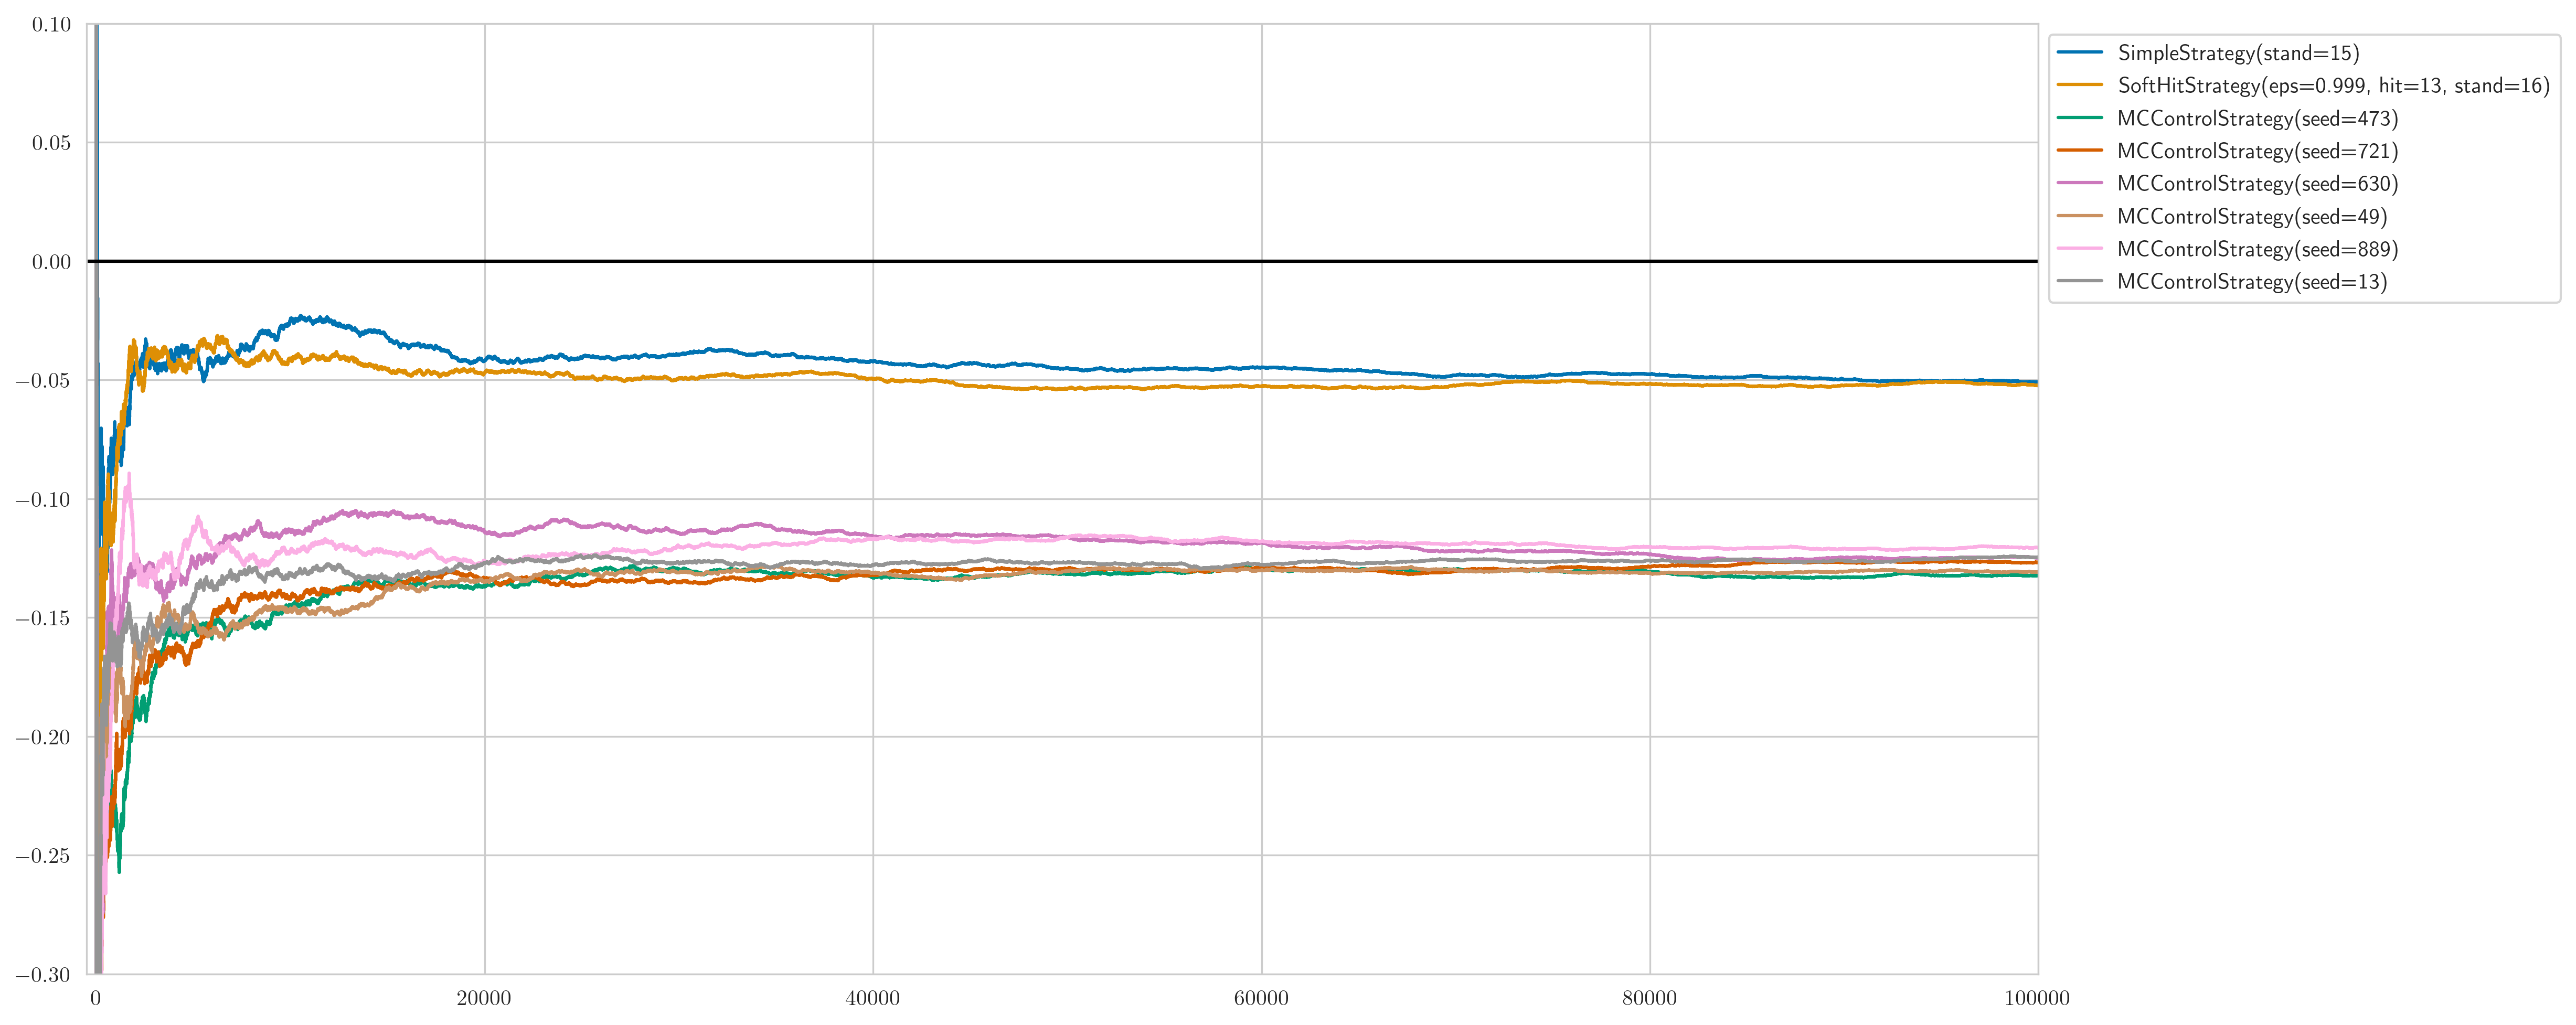

In [18]:
MAX_STRATEGIES = 10
MIN_REWARDS = -0.13

plt.figure(figsize=(16,8))

display(f"{best_strategy}: result = {best_strategy_wins[-1]}")
plt.plot(best_strategy_wins, label=best_strategy)

display(f"{best_soft_strategy}: result = {best_soft_strategy_wins[-1]}")
plt.plot(best_soft_strategy_wins, label=best_soft_strategy)

np.random.seed()
seed = np.random.randint(1000)
strategy = MCControlStrategy(seed=seed)
run_estimation(strategy)

for seed in np.random.randint(1000, size=(MAX_STRATEGIES,)):
    strategy = MCControlStrategy(seed=seed)
    run_estimation(strategy, display_result=False, min_rewards=MIN_REWARDS)

plt.axhline(y=0.0, color='black')
plt.xlim((-500, 100000))
plt.ylim((-0.3, 0.1))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [19]:
df = pd.DataFrame(strats).T \
    .sort_values(by="result",ascending=False)
 
df_mc = df[df.index.str.startswith("MC")]
df_mc.head(5)

,strategy,result,wins
MCControlStrategy(seed=13),MCControlStrategy(seed=13),-0.118877,"[1.0, 0.0, -0.3333333333333333, 0.0, -0.2, -0...."
MCControlStrategy(seed=721),MCControlStrategy(seed=721),-0.122223,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.2, -0..."
MCControlStrategy(seed=630),MCControlStrategy(seed=630),-0.122379,"[-1.0, 0.0, -0.3333333333333333, 0.0, -0.2, -0..."
MCControlStrategy(seed=49),MCControlStrategy(seed=49),-0.125919,"[-1.0, -1.0, -0.3333333333333333, -0.5, -0.2, ..."
MCControlStrategy(seed=889),MCControlStrategy(seed=889),-0.126453,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -0..."


In [20]:
class SoftMCControlStrategy(MCControlStrategy):
    """
    Monte Carlo control with soft strategies
    """
    def __init__(self, eps=0.95, seed=None, n_states=N_STATES, n_actions=N_ACTIONS):
        super().__init__(seed=seed, n_states=n_states, n_actions=n_actions)
        self.eps = eps

    def __str__(self):
        return f"SoftMCControlStrategy(eps={self.eps}, seed={self.seed})"

    def action(self, state):
        return np.argmax(self.Q[state]) if np.random.uniform() < self.eps else np.random.randint(self.n_actions)

'SimpleStrategy(stand=15): result = -0.0539715'

'SoftHitStrategy(eps=0.999, hit=13, stand=16): result = -0.052585'

'SoftMCControlStrategy(eps=0.8, seed=None): result = -0.103609'

'SoftMCControlStrategy(eps=0.9, seed=None): result = -0.0698045'

'SoftMCControlStrategy(eps=0.95, seed=None): result = -0.0559785'

'SoftMCControlStrategy(eps=0.97, seed=None): result = -0.0560875'

'SoftMCControlStrategy(eps=0.99, seed=None): result = -0.057462'

'SoftMCControlStrategy(eps=0.995, seed=None): result = -0.068053'

'SoftMCControlStrategy(eps=0.997, seed=None): result = -0.090583'

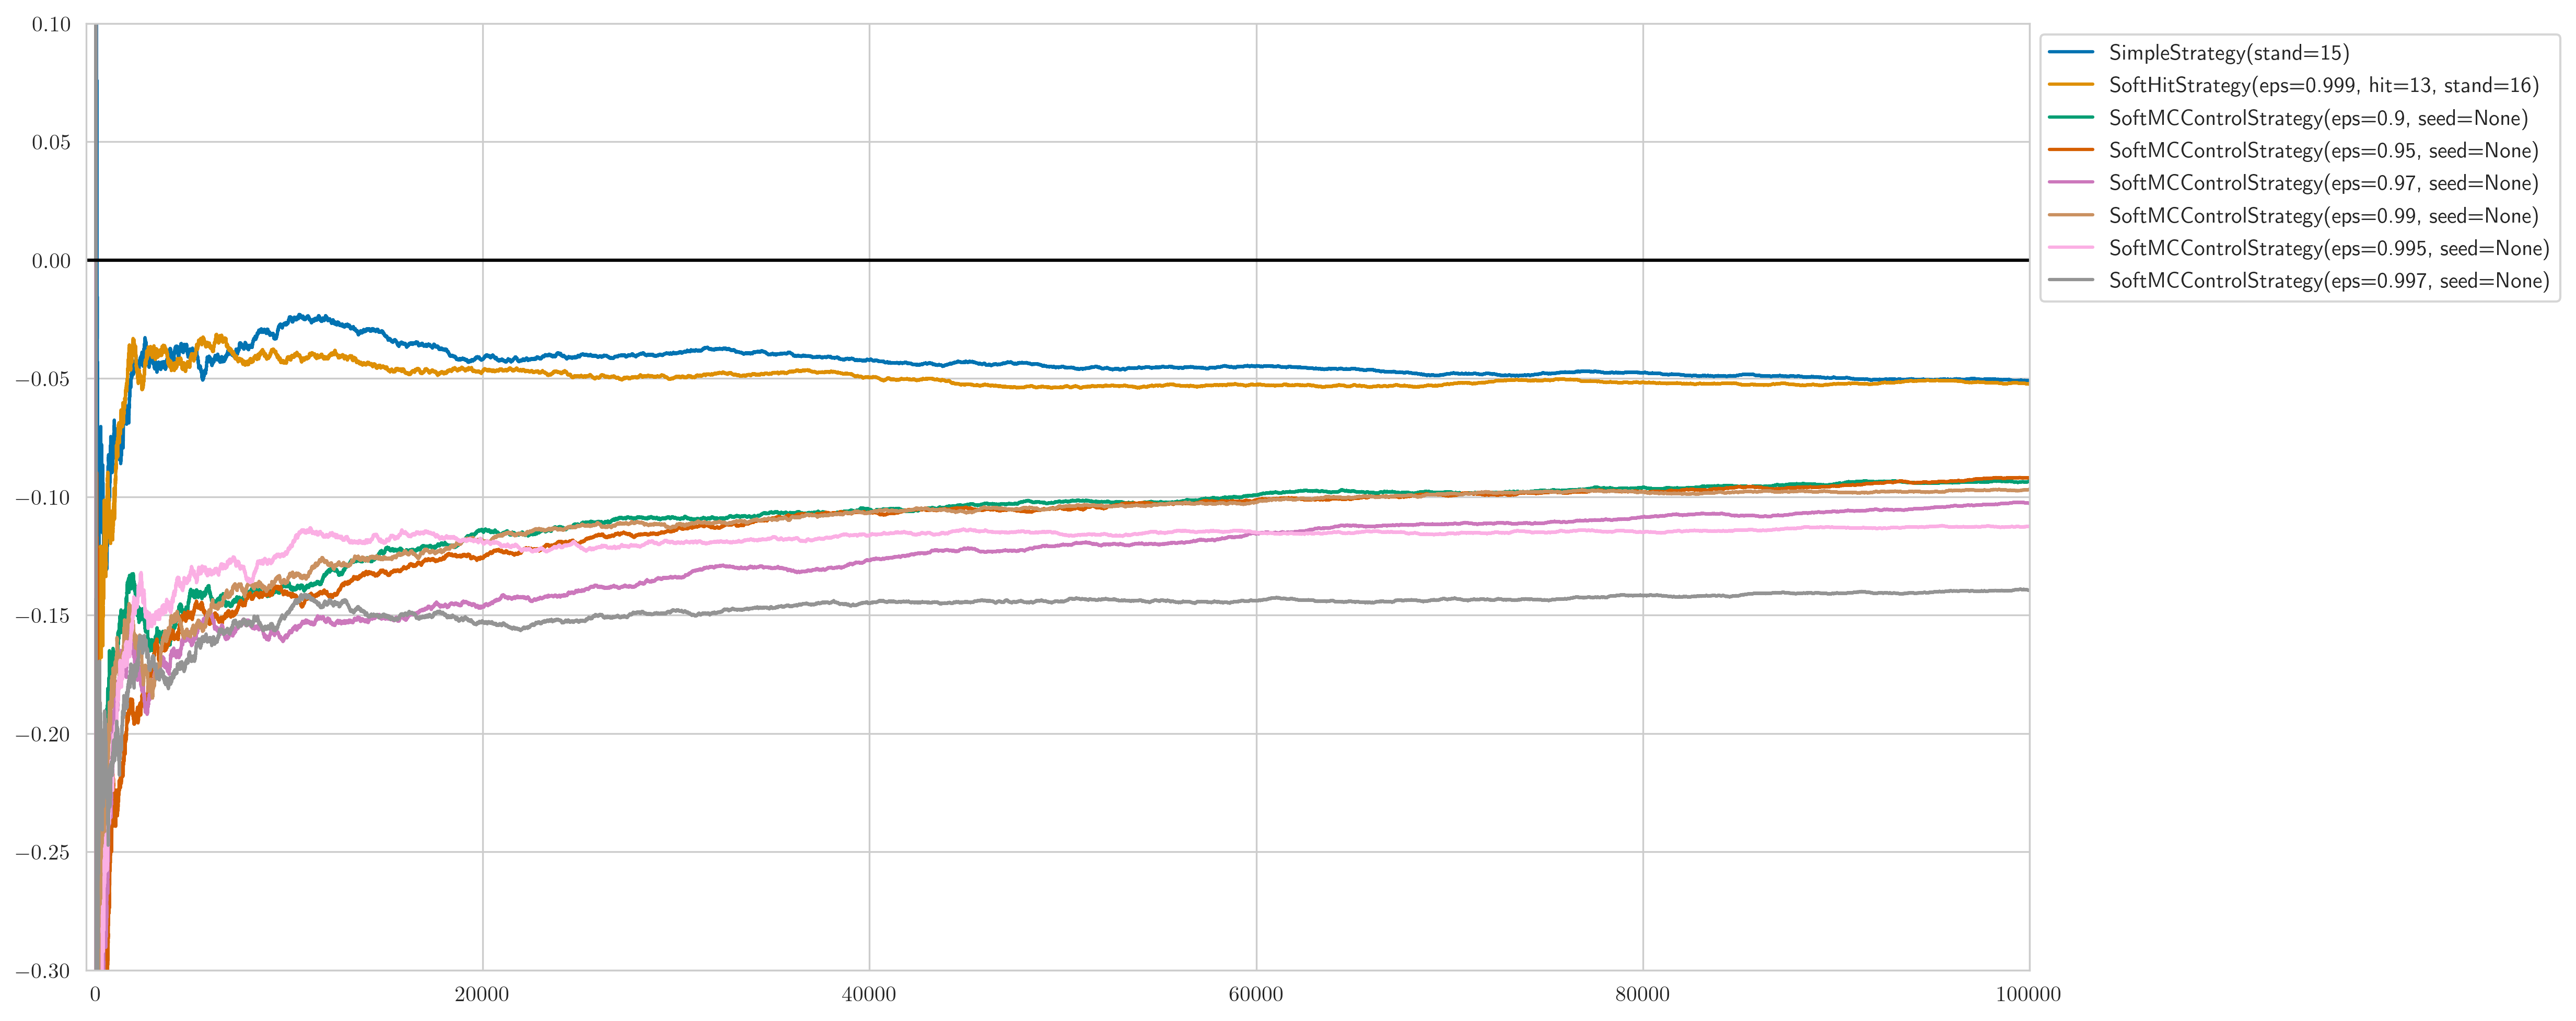

In [21]:
MAX_STRATEGIES = 10
MIN_REWARDS = -0.1

plt.figure(figsize=(16,8))

display(f"{best_strategy}: result = {best_strategy_wins[-1]}")
plt.plot(best_strategy_wins, label=best_strategy)

display(f"{best_soft_strategy}: result = {best_soft_strategy_wins[-1]}")
plt.plot(best_soft_strategy_wins, label=best_soft_strategy)

for eps in [0.8, 0.9, 0.95, 0.97, 0.99, 0.995, 0.997]:
    strategy = SoftMCControlStrategy(eps=eps)
    run_estimation(strategy, min_rewards=MIN_REWARDS)

plt.axhline(y=0.0, color='black')
plt.xlim((-500, 100000))
plt.ylim((-0.3, 0.1))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [22]:
df = pd.DataFrame(strats).T \
    .sort_values(by="result",ascending=False)

df_soft_mc = df[df.index.str.startswith("SoftMC")]
df_soft_mc.head(5)

,strategy,result,wins
"SoftMCControlStrategy(eps=0.95, seed=None)","SoftMCControlStrategy(eps=0.95, seed=None)",-0.055979,"[-1.0, -1.0, -1.0, -0.375, -0.1, -0.25, -0.357..."
"SoftMCControlStrategy(eps=0.97, seed=None)","SoftMCControlStrategy(eps=0.97, seed=None)",-0.056087,"[1.0, 1.0, 1.0, 0.75, 0.4, 0.16666666666666666..."
"SoftMCControlStrategy(eps=0.99, seed=None)","SoftMCControlStrategy(eps=0.99, seed=None)",-0.057462,"[1.0, 0.0, -0.3333333333333333, 0.0, 0.2, 0.0,..."
"SoftMCControlStrategy(eps=0.995, seed=None)","SoftMCControlStrategy(eps=0.995, seed=None)",-0.068053,"[1.0, 0.0, -0.3333333333333333, 0.0, -0.2, -0...."
"SoftMCControlStrategy(eps=0.9, seed=None)","SoftMCControlStrategy(eps=0.9, seed=None)",-0.069805,"[1.0, 1.0, 0.3333333333333333, 0.0, -0.2, -0.1..."


In [23]:
class SarsaStrategy:
    """
    Sarsa стратегия.
    """
    def __init__(self, eps=0.9, alpha=0.9, gamma=0.9, seed=None, n_states=N_STATES, n_actions=N_ACTIONS):
        self.n_states, self.n_actions = n_states, n_actions
        self.eps, self.alpha, self.gamma, self.seed = eps, alpha, gamma, seed        
        self.states, self.actions, self.rewards = [], [], []
        # first - always hit
        self.next_action = 1
        
        np.random.seed(seed)
        self.V = defaultdict(float)
        self.RetS = defaultdict(int)
        self.Q = defaultdict(lambda: [np.random.uniform() for _ in range(n_actions)])
        self.RetSA = defaultdict(lambda: [0 for _ in range(n_actions)])
                
    def __str__(self):
        return f"SarsaStrategy(eps={self.eps}, alpha={self.alpha}, gamma={self.gamma}, seed={self.seed})"
    
    def new_episode(self):
        self.states, self.rewards, self.actions = [], [], []
        # first - always hit
        self.next_action = 1
        
    def get_next_action(self, state):
        # eps-greedly strategy
        if np.random.uniform() < self.eps:
            action = np.argmax(self.Q[state])
        else:
            action = np.random.randint(self.n_actions)
        return action
        
    def action(self, state):
        # HACK
        return self.next_action if state[0] < 19 else 0
    
    def collect(self, state, action, reward, next_state):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        
        self.next_action = self.get_next_action(next_state)
        Q_St_At = self.Q[state][action]
        Q_St_At = Q_St_At + self.alpha * (reward + self.gamma * self.Q[next_state][self.next_action] - Q_St_At)
        self.Q[state][action] = Q_St_At

    def first_visit_mc(self):
        # first visit Monte Carlo estimation 
        G = 0
        for t in range(len(self.states)-1, -1, -1):
            S, A, R = self.states[t], self.actions[t], self.rewards[t]
            G += R
            if S not in self.states[:t]:
                self.RetS[S] += 1
                self.V[S] += (G - self.V[S]) / self.RetS[S]


'SimpleStrategy(stand=15): result = -0.0539715'

'SoftHitStrategy(eps=0.999, hit=13, stand=16): result = -0.052585'

100%|█████████████████████████████████████████████| 5/5 [04:27<00:00, 53.49s/it]


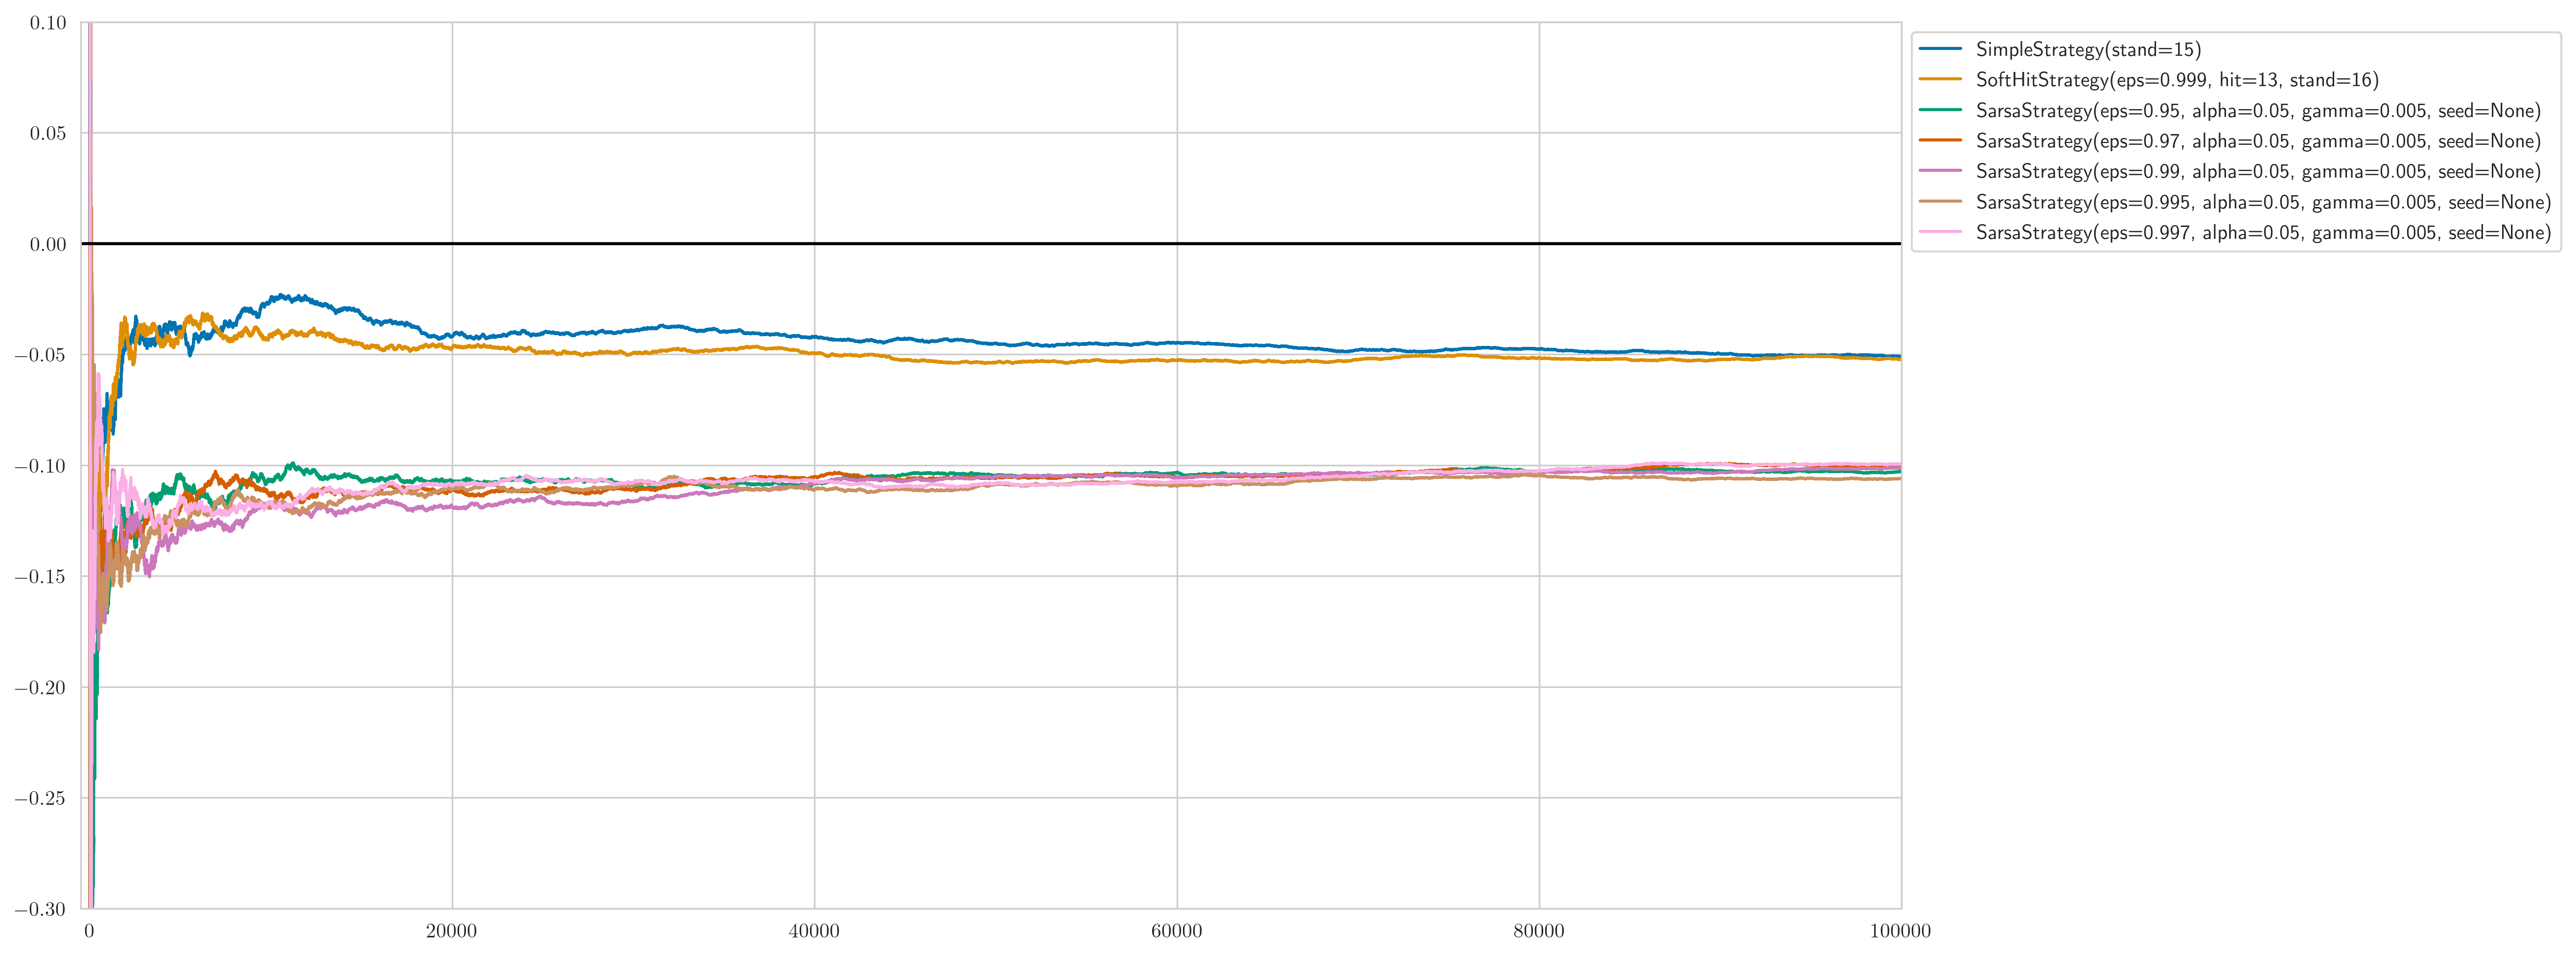

In [33]:
MAX_STRATEGIES = 10
MIN_REWARDS = -0.1

GS_EPISODES = 100_000
GS_SAMPLES = 3

plt.figure(figsize=(16,8))

display(f"{best_strategy}: result = {best_strategy_wins[-1]}")
plt.plot(best_strategy_wins, label=best_strategy)

display(f"{best_soft_strategy}: result = {best_soft_strategy_wins[-1]}")
plt.plot(best_soft_strategy_wins, label=best_soft_strategy)


# # grid search
# np.random.seed()
# seeds = [r for r in np.random.randint(100, size=GS_SAMPLES)]
# for alpha in tqdm([0.01, 0.05, 0.1, 0.15]):
#     for gamma in [0.0005, 0.001, 0.005, 0.01]:
#         np.random.seed()
#         for seed in seeds:
#             strategy = SarsaStrategy(eps=eps, alpha=alpha, gamma=gamma, seed=seed)
#             run_estimation(strategy, n_episodes=GS_EPISODES, display_result=False, min_rewards=MIN_REWARDS)

                
for eps in tqdm([0.95, 0.97, 0.99, 0.995, 0.997]):
    strategy = SarsaStrategy(eps=eps, alpha=0.05, gamma=0.005)
    run_estimation(strategy, display_result=False, min_rewards=MIN_REWARDS)

    
plt.axhline(y=0.0, color='black')
plt.xlim((-500, 100000))
plt.ylim((-0.3, 0.1))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [34]:
df = pd.DataFrame(strats).T \
    .sort_values(by="result",ascending=False)

df_sarsa = df[df.index.str.startswith("Sarsa")]
df_sarsa.head(10)

,strategy,result,wins
"SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=None)","SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.00...",-0.096071,"[0.0, 0.0, -0.3333333333333333, 0.0, -0.2, 0.0..."
"SarsaStrategy(eps=0.99, alpha=0.05, gamma=0.005, seed=None)","SarsaStrategy(eps=0.99, alpha=0.05, gamma=0.00...",-0.096607,"[-1.0, -1.0, -1.0, -1.0, -1.0, -0.666666666666..."
"SarsaStrategy(eps=0.997, alpha=0.05, gamma=0.005, seed=None)","SarsaStrategy(eps=0.997, alpha=0.05, gamma=0.0...",-0.096657,"[1.0, 1.0, 1.0, 0.75, 0.4, 0.5, 0.285714285714..."
"SarsaStrategy(eps=0.995, alpha=0.05, gamma=0.005, seed=None)","SarsaStrategy(eps=0.995, alpha=0.05, gamma=0.0...",-0.096663,"[-1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -..."
"SarsaStrategy(eps=0.997, alpha=0.1, gamma=0.005, seed=13)","SarsaStrategy(eps=0.997, alpha=0.1, gamma=0.00...",-0.09718,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -0..."
"SarsaStrategy(eps=0.997, alpha=0.15, gamma=0.005, seed=65)","SarsaStrategy(eps=0.997, alpha=0.15, gamma=0.0...",-0.09794,"[1.0, 1.0, 0.3333333333333333, 0.25, 0.4, 0.16..."
"SarsaStrategy(eps=0.997, alpha=0.05, gamma=0.01, seed=13)","SarsaStrategy(eps=0.997, alpha=0.05, gamma=0.0...",-0.098665,"[-1.0, 0.0, -0.3333333333333333, 0.0, 0.2, 0.0..."
"SarsaStrategy(eps=0.997, alpha=0.05, gamma=0.0005, seed=7)","SarsaStrategy(eps=0.997, alpha=0.05, gamma=0.0...",-0.098675,"[0.0, -0.5, 0.0, -0.25, 0.0, -0.16666666666666..."
"SarsaStrategy(eps=0.997, alpha=0.1, gamma=0.0005, seed=65)","SarsaStrategy(eps=0.997, alpha=0.1, gamma=0.00...",-0.09878,"[-1.0, -1.0, -1.0, -0.5, -0.1, -0.25, -0.35714..."
"SarsaStrategy(eps=0.95, alpha=0.05, gamma=0.005, seed=None)","SarsaStrategy(eps=0.95, alpha=0.05, gamma=0.00...",-0.099774,"[-1.0, -1.0, -1.0, -0.5, -0.6, -0.666666666666..."


In [26]:
class QlearningStrategy:
    """
    Q-learning стратегия.
    """
    def __init__(self, eps=0.9, alpha=0.9, gamma=0.9, seed=None, n_states=N_STATES, n_actions=N_ACTIONS):
        self.n_states, self.n_actions = n_states, n_actions
        self.eps, self.alpha, self.gamma, self.seed = eps, alpha, gamma, seed        
        self.states, self.actions, self.rewards = [], [], []
        
        np.random.seed(seed)
        self.V = defaultdict(float)
        self.RetS = defaultdict(int)
        self.Q = defaultdict(lambda: [np.random.uniform() for _ in range(n_actions)])
        self.RetSA = defaultdict(lambda: [0 for _ in range(n_actions)])
                
    def __str__(self):
        return f"QlearningStrategy(eps={self.eps}, alpha={self.alpha}, gamma={self.gamma}, seed={self.seed})"
    
    def new_episode(self):
        self.states, self.rewards, self.actions = [], [], []
        
    def action(self, state):
        # eps-greedly strategy
        if np.random.uniform() < self.eps:
            action = np.argmax(self.Q[state])
        else:
            action = np.random.randint(self.n_actions)
        return action
    
    def collect(self, state, action, reward, next_state):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        
        Q_St_next = np.amax(self.Q[next_state])
        Q_St_At = self.Q[state][action]
        Q_St_At = Q_St_At + self.alpha * (reward + self.gamma * Q_St_next - Q_St_At)
        self.Q[state][action] = Q_St_At

    def first_visit_mc(self):
        # first visit Monte Carlo estimation 
        G = 0
        for t in range(len(self.states)-1, -1, -1):
            S, A, R = self.states[t], self.actions[t], self.rewards[t]
            G += R
            if S not in self.states[:t]:
                self.RetS[S] += 1
                self.V[S] += (G - self.V[S]) / self.RetS[S]


'SimpleStrategy(stand=15): result = -0.0539715'

'SoftHitStrategy(eps=0.999, hit=13, stand=16): result = -0.052585'

100%|█████████████████████████████████████████████| 5/5 [05:22<00:00, 64.54s/it]


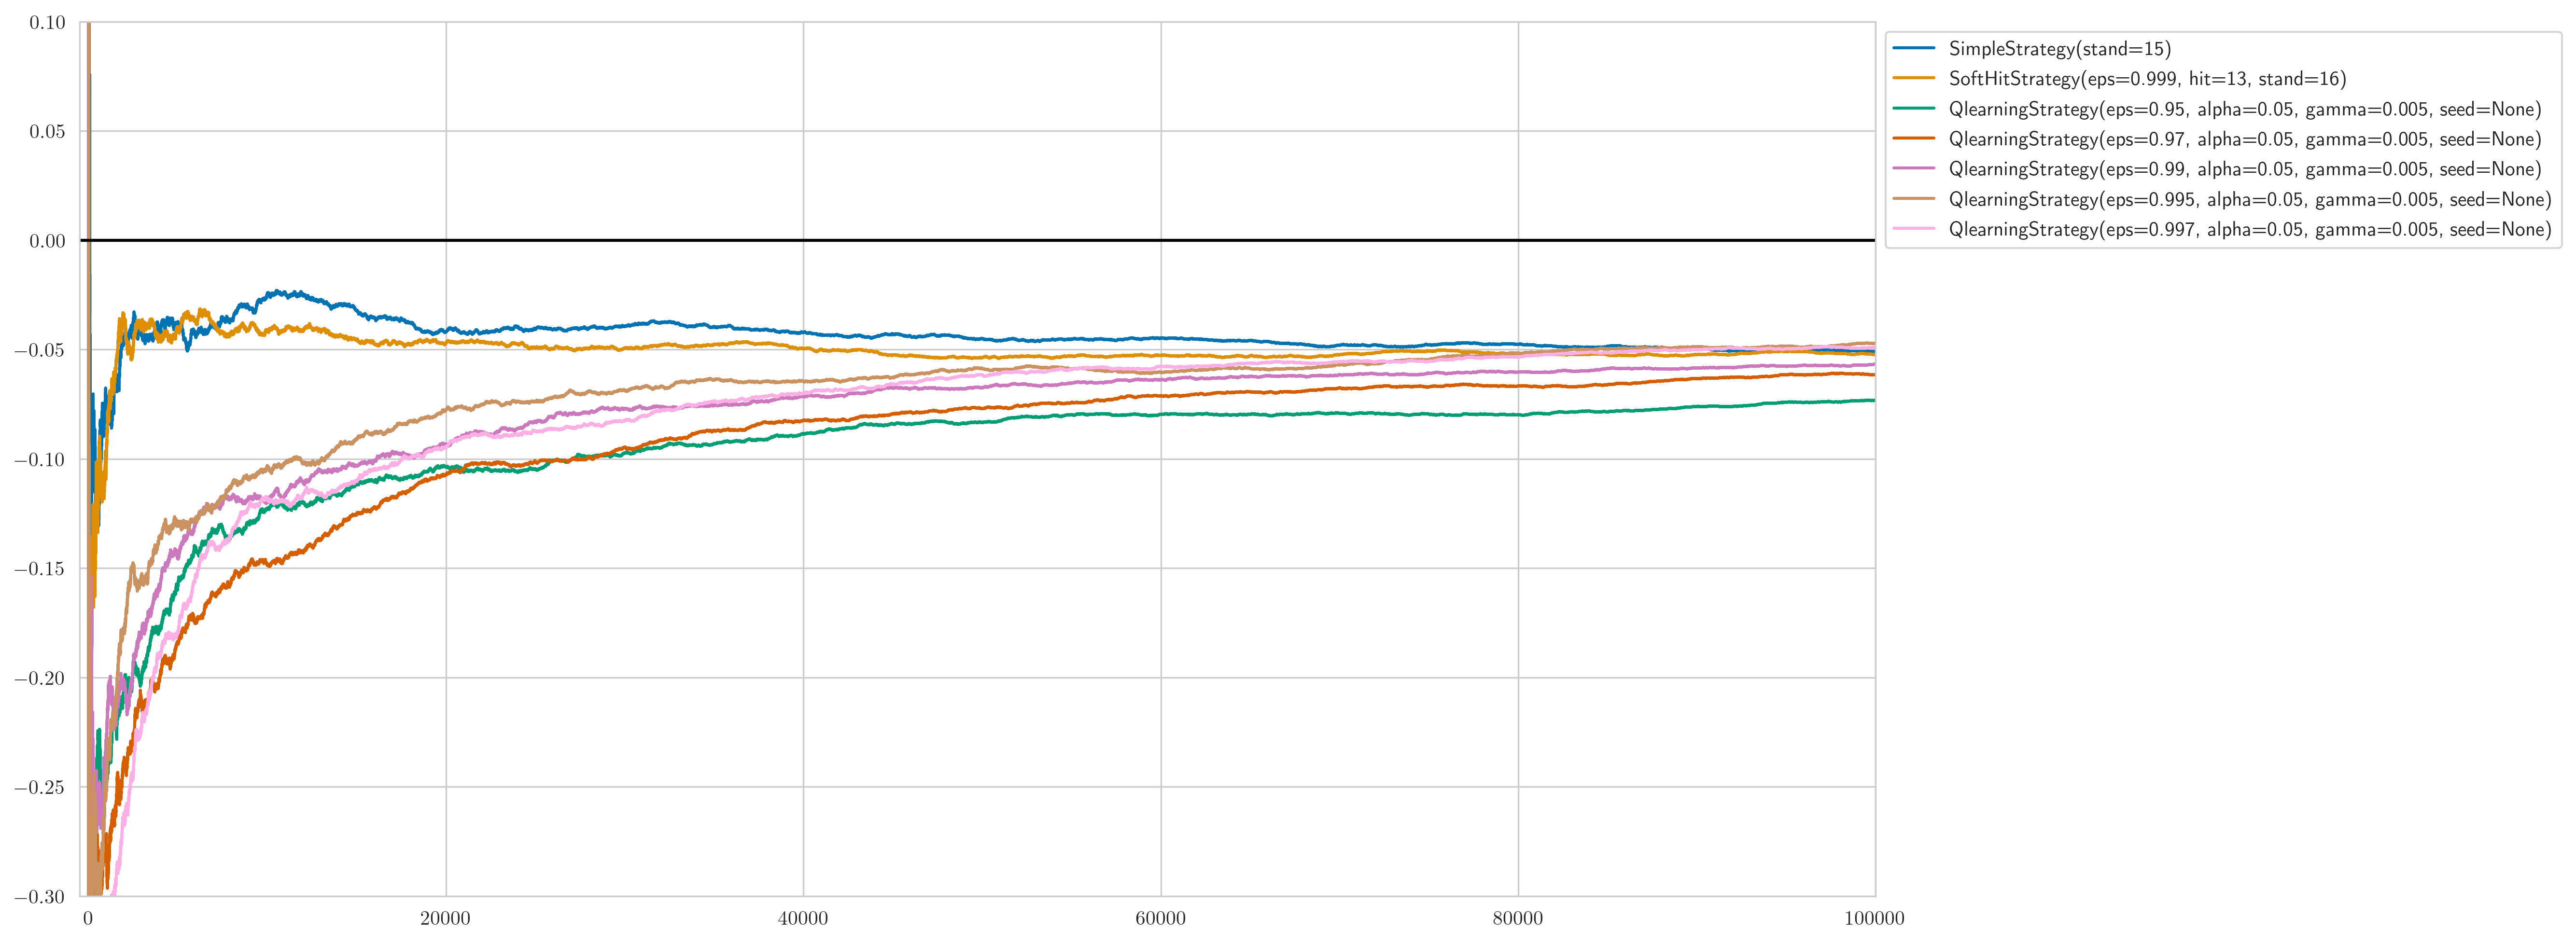

In [35]:
MAX_STRATEGIES = 10
MIN_REWARDS = -0.6

GS_EPISODES = 100_000
GS_SAMPLES = 3

plt.figure(figsize=(16,8))

display(f"{best_strategy}: result = {best_strategy_wins[-1]}")
plt.plot(best_strategy_wins, label=best_strategy)

display(f"{best_soft_strategy}: result = {best_soft_strategy_wins[-1]}")
plt.plot(best_soft_strategy_wins, label=best_soft_strategy)


# # grid search
# np.random.seed()
# seeds = [r for r in np.random.randint(100, size=GS_SAMPLES)]
# for alpha in tqdm([0.05, 0.1, 0.15]):
#     for gamma in [0.0005, 0.001, 0.005, 0.01]:
#         np.random.seed()
#         for seed in seeds:
#             strategy = QlearningStrategy(eps=eps, alpha=alpha, gamma=gamma, seed=seed)
#             run_estimation(strategy, n_episodes=GS_EPISODES, display_result=False, min_rewards=MIN_REWARDS)

for eps in tqdm([0.95, 0.97, 0.99, 0.995, 0.997]):
    strategy = QlearningStrategy(eps=eps, alpha=0.05, gamma=0.005)
    run_estimation(strategy, display_result=False, min_rewards=MIN_REWARDS)


plt.axhline(y=0.0, color='black')
plt.xlim((-500, 100000))
plt.ylim((-0.3, 0.1))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [28]:
df = pd.DataFrame(strats).T \
    .sort_values(by="result",ascending=False)

df_qlearn = df[df.index.str.startswith("Qlearn")]
df_qlearn.head(5)

,strategy,result,wins
"QlearningStrategy(eps=0.995, alpha=0.1, gamma=0.01, seed=None)","QlearningStrategy(eps=0.995, alpha=0.1, gamma=...",-0.047203,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.2, 0...."
"QlearningStrategy(eps=0.997, alpha=0.1, gamma=0.01, seed=None)","QlearningStrategy(eps=0.997, alpha=0.1, gamma=...",-0.047571,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -0..."
"QlearningStrategy(eps=0.99, alpha=0.1, gamma=0.01, seed=None)","QlearningStrategy(eps=0.99, alpha=0.1, gamma=0...",-0.047666,"[1.0, 0.5, 0.0, -0.25, -0.4, -0.5, -0.28571428..."
"QlearningStrategy(eps=0.97, alpha=0.1, gamma=0.01, seed=None)","QlearningStrategy(eps=0.97, alpha=0.1, gamma=0...",-0.055515,"[-1.0, -1.0, -1.0, -1.0, -0.8, -0.833333333333..."
"QlearningStrategy(eps=0.95, alpha=0.1, gamma=0.01, seed=None)","QlearningStrategy(eps=0.95, alpha=0.1, gamma=0...",-0.064001,"[0.0, -0.5, -0.3333333333333333, 0.0, 0.3, 0.2..."


# Лучшие стратегии

In [36]:
df.head(10)

,strategy,result,wins
"QlearningStrategy(eps=0.995, alpha=0.1, gamma=0.01, seed=None)","QlearningStrategy(eps=0.995, alpha=0.1, gamma=...",-0.047203,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.2, 0...."
"QlearningStrategy(eps=0.997, alpha=0.1, gamma=0.01, seed=None)","QlearningStrategy(eps=0.997, alpha=0.1, gamma=...",-0.047571,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -0..."
"QlearningStrategy(eps=0.99, alpha=0.1, gamma=0.01, seed=None)","QlearningStrategy(eps=0.99, alpha=0.1, gamma=0...",-0.047666,"[1.0, 0.5, 0.0, -0.25, -0.4, -0.5, -0.28571428..."
"SoftHitStrategy(eps=0.999, hit=13, stand=16)","SoftHitStrategy(eps=0.999, hit=13, stand=16)",-0.052585,"[-1.0, -1.0, -1.0, -1.0, -0.8, -0.833333333333..."
"SoftHitStrategy(eps=0.99, hit=13, stand=15)","SoftHitStrategy(eps=0.99, hit=13, stand=15)",-0.052795,"[1.0, 1.0, 0.3333333333333333, 0.0, -0.2, -0.3..."
"SoftHitStrategy(eps=0.99, hit=14, stand=16)","SoftHitStrategy(eps=0.99, hit=14, stand=16)",-0.053191,"[1.0, 0.0, -0.3333333333333333, 0.0, -0.2, 0.0..."
"SoftHitStrategy(eps=0.99, hit=13, stand=16)","SoftHitStrategy(eps=0.99, hit=13, stand=16)",-0.053747,"[-1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -..."
"SoftHitStrategy(eps=0.97, hit=14, stand=16)","SoftHitStrategy(eps=0.97, hit=14, stand=16)",-0.053823,"[1.0, 1.0, 0.3333333333333333, 0.5, 0.2, 0.333..."
"SoftHitStrategy(eps=0.997, hit=14, stand=16)","SoftHitStrategy(eps=0.997, hit=14, stand=16)",-0.053892,"[0.0, -0.5, 0.0, 0.25, 0.4, 0.5, 0.57142857142..."
SimpleStrategy(stand=15),SimpleStrategy(stand=15),-0.053971,"[-1.0, 0.0, 0.3333333333333333, 0.0, -0.2, -0...."


# Худшие стратегии

In [30]:
df.tail(10)

,strategy,result,wins
MCControlStrategy(seed=49),MCControlStrategy(seed=49),-0.125919,"[-1.0, -1.0, -0.3333333333333333, -0.5, -0.2, ..."
MCControlStrategy(seed=889),MCControlStrategy(seed=889),-0.126453,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -0..."
MCControlStrategy(seed=473),MCControlStrategy(seed=473),-0.130103,"[1.0, 0.0, -0.3333333333333333, -0.5, -0.6, -0..."
MCControlStrategy(seed=611),MCControlStrategy(seed=611),-0.131141,"[1.0, 0.0, 0.3333333333333333, 0.625, 0.3, 0.0..."
MCControlStrategy(seed=204),MCControlStrategy(seed=204),-0.134191,"[1.0, 0.5, 0.6666666666666666, 0.75, 0.4, 0.16..."
MCControlStrategy(seed=84),MCControlStrategy(seed=84),-0.139553,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0...."
MCControlStrategy(seed=660),MCControlStrategy(seed=660),-0.147978,"[-1.0, 0.0, -0.3333333333333333, -0.5, -0.2, -..."
MCControlStrategy(seed=215),MCControlStrategy(seed=215),-0.148095,"[-1.0, 0.0, -0.3333333333333333, 0.0, 0.2, 0.4..."
BaselineStrategy,BaselineStrategy,-0.165967,"[1.0, 0.0, -0.3333333333333333, 0.0, -0.2, 0.0..."
SimpleStrategy(stand=19),SimpleStrategy(stand=19),-0.179283,"[-1.0, -1.0, -1.0, -0.5, -0.6, -0.333333333333..."


# Выводы

- Просто добирать до 19 - плохая стратегия

- Неплохие стратегии - добирать до 15 или 16, эти стратегии не хуже дилера

- Для мягкой простой стратегии лучше сначала добирать до 13 или 14, а потом положиться на "random"

- MC-control стратегии показали большой разброс результатов в зависимости от начального заполнения Q-функции

- Сравнительно неплохие результаты у мягких MC-control стратегий, но также большой разброс в зависимости от начального заполнения 'SoftMCControlStrategy(eps=0.95, seed=None): result = -0.0559785' или 'SoftMCControlStrategy(eps=0.97, seed=None): result = -0.0560875'

- Sarsa стратегии работают плохо, из-за того что в игре короткие эпизоды

- Q-learning стратегии сработали лучше всего, и кажется, что на 1М эпизодов они все еще не до конца сошлись

'QlearningStrategy(eps=0.995, alpha=0.1, gamma=0.01, seed=None): result = -0.047203'

'QlearningStrategy(eps=0.997, alpha=0.1, gamma=0.01, seed=None): result = -0.047571'

'QlearningStrategy(eps=0.99, alpha=0.1, gamma=0.01, seed=None): result = -0.047666'

'SoftHitStrategy(eps=0.999, hit=13, stand=16): result = -0.052585'

'SoftHitStrategy(eps=0.99, hit=13, stand=15): result = -0.052795'

'SoftHitStrategy(eps=0.99, hit=14, stand=16): result = -0.0531905'

'SoftHitStrategy(eps=0.99, hit=13, stand=16): result = -0.0537465'

'SoftHitStrategy(eps=0.97, hit=14, stand=16): result = -0.053823'

'SoftHitStrategy(eps=0.997, hit=14, stand=16): result = -0.0538915'

'SimpleStrategy(stand=15): result = -0.0539715'

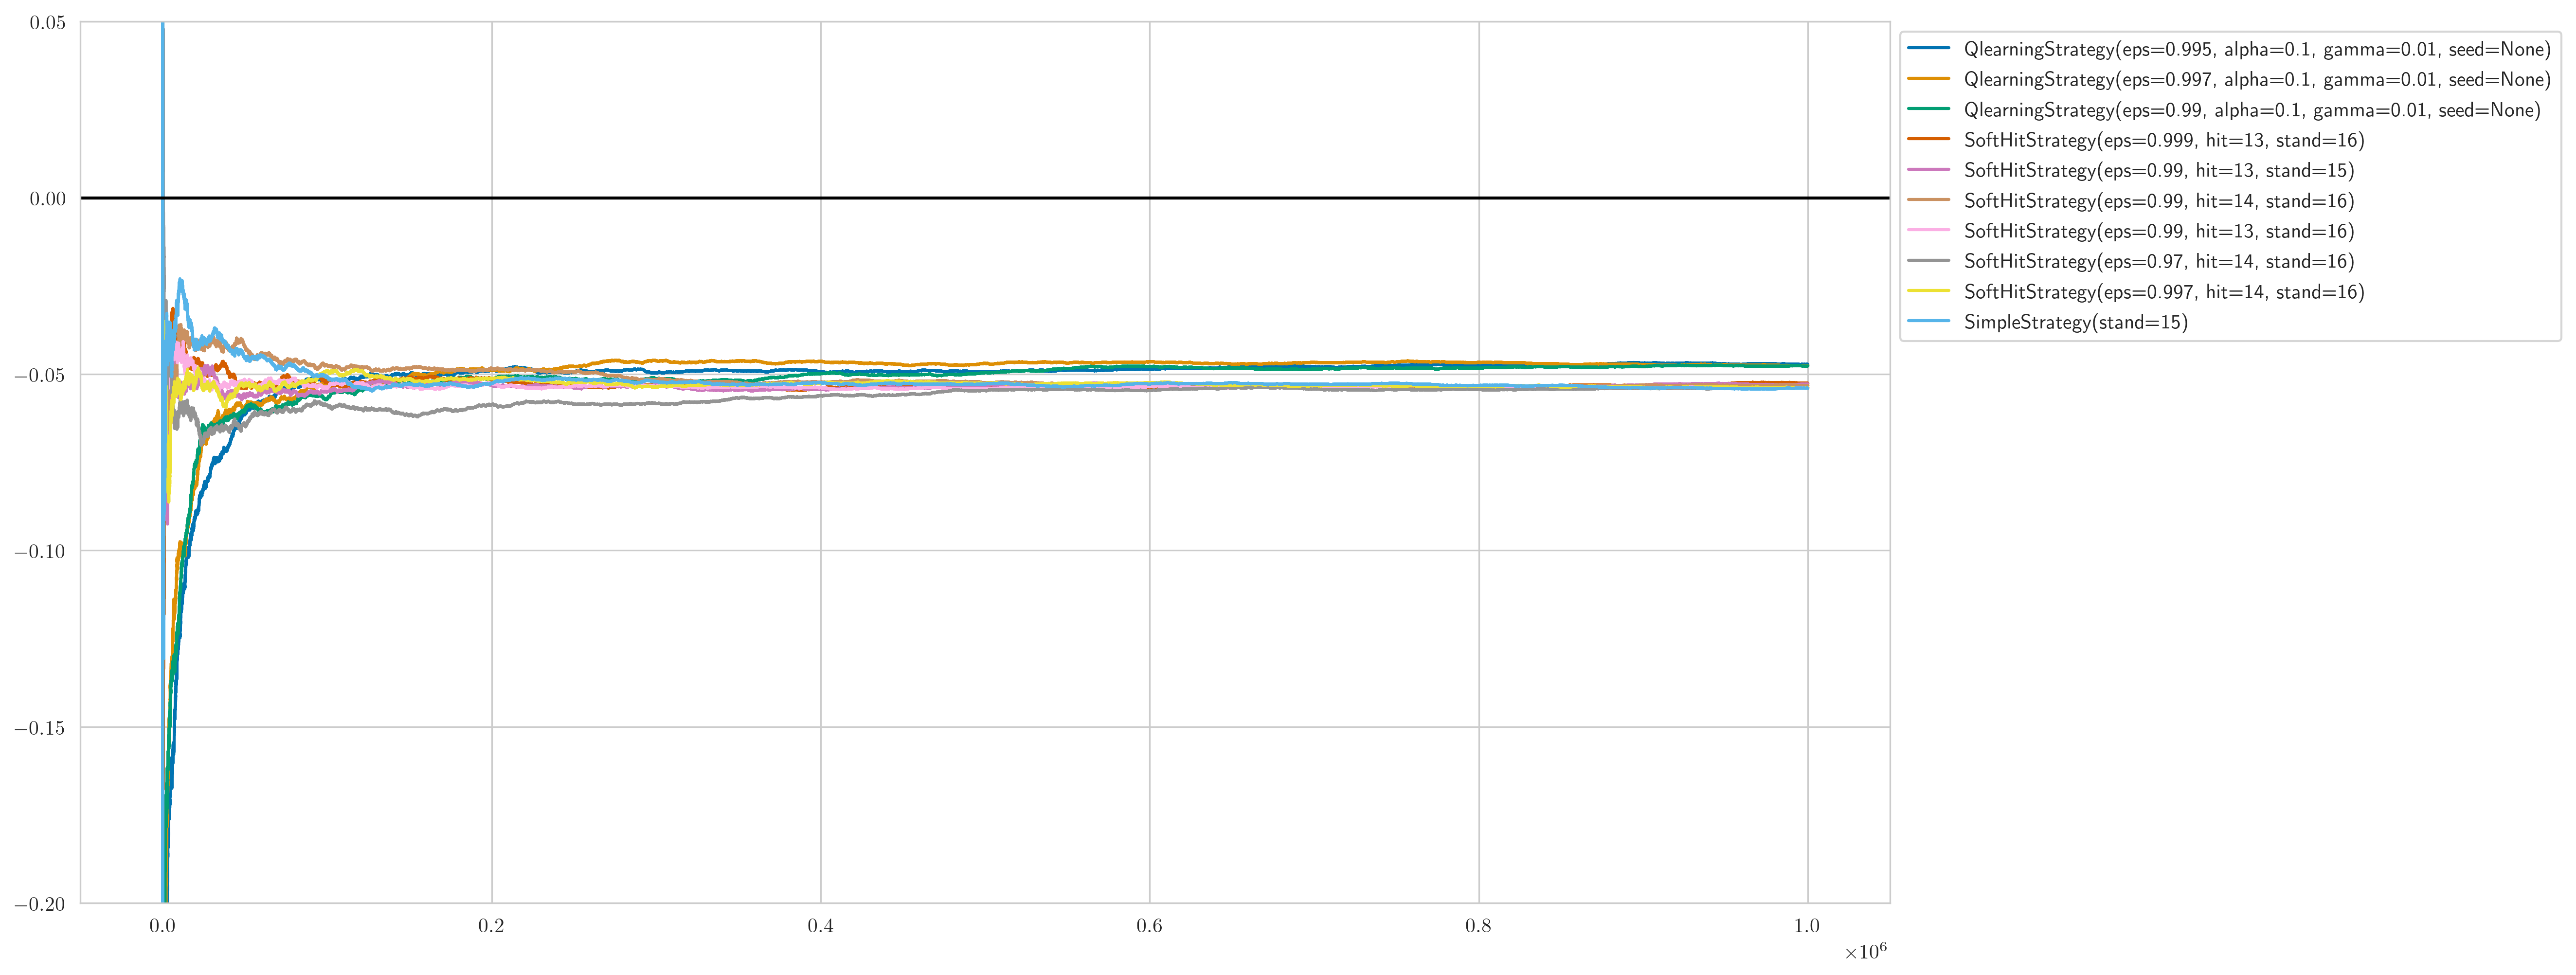

In [46]:
plt.figure(figsize=(16, 8))

for s in df.head(10).index:
    display(f"{s}: result = {df.loc[s,'result']}")
    plt.plot(df.loc[s,"wins"], label=s)
    
plt.axhline(y=0.0, color='black')
#plt.xlim((-500, 100000))
plt.ylim((-0.2, 0.05))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()